In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist, pos_tag
import re
import sys

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import json

sns.set_style('darkgrid')

In [2]:
with open ('./data/json_pr.json') as x:
    prj = json.load(x)
    
with open ('./data/json_ra.json') as y:
    raj = json.load(y)

In [3]:
df_prj = pd.DataFrame(prj)
df_raj = pd.DataFrame(raj)

In [4]:
# #confirm latest dfs: 0 nulls.  confirmed
# print(df_prj.isnull().sum())
# print(df_raj.isnull().sum())

# All posts left in original format, no special character elimination

# Structure analysis separate from diction:

Number of sentences, sentence length, and *rate* of punctuation use (. , ?) could be informative.  How preserve?  

2 separate analyses: nlp based on Bag of Words (0 structure or punctuation retention), and one based on structure.  

Word Frequencies (see lesson 5.04) counts *everything* - punctuation, numbers, etc.  But I'd rather use WordFreq, CountVec, etc for lexicon and reduce punctuation down to counts.

New columns for total wordcount, # sentences, average sentence length, total commas / ? / ! (which can be changed into per wordcount or per sentence 'rates' later).  

### Add column with sentence count
Methods based on experimentation in scratch notebook

In [5]:
df_prj['num_sentences'] = df_prj['selftext'].map(lambda x: len(re.split(r'[.!?]+', x))-1)
df_raj['num_sentences'] = df_raj['selftext'].map(lambda x: len(re.split(r'[.!?]+', x))-1)

### Add column with average sentence length (by word)

In [6]:
# len counts spaces and characters.  you want wordcount.
length = 'this is twenty lettersS..!?,'
len(length)

28

In [7]:
#df_raj_mini['words_per_sentence'] = 

def avg_words_per_sentence(df):
    
    all_sentences_bypost = []

    for i in df['selftext']:
        all_sentences_bypost.append(re.split(r'[.!?]+', i))
    
    avgwordsper = []

    for post in all_sentences_bypost:
        wordspersentence = []
        for i in post:
            wordspersentence.append(len(i.split()))
        avgwordsper.append(int(np.mean(wordspersentence).round()))
        
    return avgwordsper

In [8]:
df_raj['avg_words_per_sent'] = avg_words_per_sentence(df_raj)
df_prj['avg_words_per_sent'] = avg_words_per_sentence(df_prj)

### Add columns with total wordcount, commas, ?s, and !s

In [9]:
df_raj['wordcount'] = df_raj['selftext'].map(lambda x: len(x.split()))
df_prj['wordcount'] = df_prj['selftext'].map(lambda x: len(x.split()))

In [10]:
df_raj['comma_count'] = df_raj['selftext'].map(lambda x: x.count(','))
df_raj['qmark_count'] = df_raj['selftext'].map(lambda x: x.count('?'))
df_raj['exclamatios'] = df_raj['selftext'].map(lambda x: x.count('!'))

In [11]:
def count_punc(punc, df):
    perpost = []
    for i in df['selftext']:
        perpost.append(i.count(punc))
    return perpost

In [12]:
df_prj['comma_count'] = count_punc(',', df_prj)
df_prj['qmark_count'] = count_punc('?', df_prj)
df_prj['exclamatios'] = count_punc('!', df_prj)

In [13]:
## No. Use total comma count, ! count, ? count
## Can turn into 'rate' later.  Prob by sentence count, not wordcount...

# def punc_rate(punctuation, df):
    
#     puncs=[]
#     punc_rate=[]
    
#     for i in df['selftext']:
#         commas.append(len(re.findall(punctuation, i)))
    
#     for j in commas:
#         comma_rate.append(commas[j]/df['wordcount'][j])
        
#     return punc_rate

In [14]:
# df_raj['comma_rate'] = punc_rate(',', df_raj)
# df_prj['comma_rate'] = punc_rate(',', df_prj)

In [15]:
#overly complicated just use map + str.count
# run into issues with 0s with re.findall I think

# def punc_count(punc, df):
#     count = []
#     for i in df['selftext']:
#         count.append(len(re.findall(punc, i)))
#     return count

### Add column is_mobile to distinguish if posted by mobile user
Users generally announce '(on) Mobile" if they are posting from mobile phones, but there is no consistent format to this announcement.  Sometimes it's a sentence, sometimes a single word declaration.  ID'ing is_mobile by simply searching for the word 'mobile' will also flag posts containing words like 'automobile', 'immobile', 'mobile bank account', etc ('shitmobile' is one I found that I did not expect...).  
Spot check 100 posts from each df to get rate of false positives to see if an is_mobile column is informative.

---

Results from check: 
* relationship_advice had 10.6% false positives (10 of total 94)
* pettyrev had 8% false positive rate (8 of 100 random checks without replacement, total count 395)  

##### Assume a fp rate of 9%, still worth identifying.  Pretty consistent fp rate across both dataframes makes it a reliable enough metric.  Concatenate before adding column. 

In [16]:
#use ctrl-f in jq pretty-print to check if posting from mobile, or talking about mobile homes, etc. 
df_raj.loc[df_raj['selftext'].str.lower().str.contains('mobile')].to_json('./scratch/is_mobile_ra.json', orient='records')

In [17]:
# 10/94 records containing 'mobile' NOT posted from mobile user 
#is_mobile = false positive rate 10.6% for RA
df_raj.loc[df_raj['selftext'].str.lower().str.contains('mobile')].shape

(94, 16)

In [18]:
# repeat for pettyrev.  len = 395.  check first 100.
df_prj.loc[df_prj['selftext'].str.lower().str.contains('mobile')].head(100).to_json('./scratch/is_mobile_pr.json', orient='records')

In [19]:
combo_structured = pd.concat([df_prj, df_raj], axis = 0, ignore_index=True)

In [20]:
combo_structured['is_mobile'] = combo_structured['selftext'].apply(lambda x: 1 if 'mobile' in x.lower() else 0)

In [21]:
combo_structured.is_mobile.value_counts()

0    11519
1      489
Name: is_mobile, dtype: int64

## Special characters to scrub:
* **all URLs:  start with https://...** 
* characters with alphanum attached: I think remove these whole units first (or the attached text), otherwise left with 'n', 'amp', 'u username', etc that won't be picked up by subsequent alphanum filter?
    * ' & amp ;
    * \n
    * u/username
    * (Mobile)
        * edit: leave mobile in place, could be differentiating feature between subreddits
        * edit 2: no matter if scrub or not, already have column indicating is_mobile
* all non-alpha-numerics: \, /, &, * , "", '', -
* emojis 
* I don't think numbers will be informative
* stopwords='english' : word freq table for petty revenge showed top words were all stopwords.  Not informative.

In [22]:
combo_structured['mod_selftext'] = combo_structured['selftext']

In [23]:
#start with urls so you don't accidentally turn them into text by ditching identifying characters
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: re.sub(r'http\S+', '', x))

In [24]:
# word_tokenizer drops many special characters but keeps 'amp' from &amp;
# drop that unit specifically first:
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: x.replace('&amp;',''))
#also apostrophes: just merge into one word (don't -> dont)
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: x.replace("'",''))

In [25]:
test = "could've would've don't I'm isn't"
test.replace("'",'')

'couldve wouldve dont Im isnt'

In [26]:
#word_tokenize then return only alpha characters re-joined in original order
#NUMBERS removed
#special characters removed
tokenizer = RegexpTokenizer(r'\w+')

In [27]:
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: ' '.join([i for i in tokenizer.tokenize(x.lower()) if i.isascii() and i.isalpha()]))

In [28]:
lemmatizer = WordNetLemmatizer()
combo_structured['lem_selftext'] = combo_structured['mod_selftext'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()]))

In [29]:
#export csv and json versions
combo_structured.to_csv('./data/allposts_struc.csv', index=False)
combo_structured.to_json('./data/j_allposts_struc.json', orient='records')

### EDA on Word Counts
Bagowords['mod_selftext] is pre-processed for Vectorizing: numbers and special characters are removed, everything is lowercase, URLs removed.  
Remove stopwords during vectorization.

---

Ran with non-lemmatized and lemmatized posts.  Lemmatization reduced columns of cvec features by 5,000.  Work with lemmatized data for 'parsimony'. Ha.

In [30]:
cvec = CountVectorizer(stop_words = 'english')
allposts_cvec = cvec.fit_transform(combo_structured['mod_selftext'])

In [31]:
df_allposts_cvec = pd.DataFrame(allposts_cvec.todense(), columns=cvec.get_feature_names())

In [32]:
df_allposts_cvec.shape #38_669 columns

(12008, 38669)

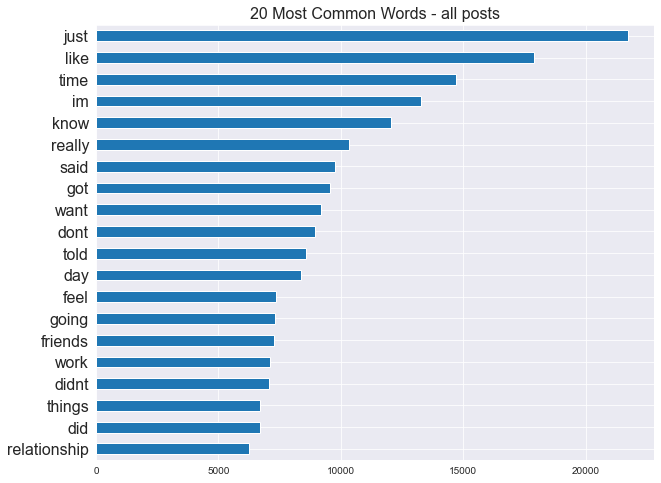

In [33]:
plt.figure(figsize=(10,8))
df_allposts_cvec.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('20 Most Common Words - all posts', size=16);

#### Compare against lemmatized posts

In [34]:
lemstop = WordNetLemmatizer()
lemmatized_stopwords = [lemstop.lemmatize(i) for i in stopwords.words('english')]
# lemmatized_stopwords

In [35]:
#lists look v. similar. any differences?
#running with just lemmatized_stopwords somehow increases columns
compare_lemmatized = list(zip(stopwords.words('english'), lemmatized_stopwords))
[i for i in compare_lemmatized if i[0] != i[1]]

[('its', 'it'), ('was', 'wa'), ('has', 'ha'), ('does', 'doe'), ('as', 'a')]

In [36]:
#custom stopwords: 'english', + unique lems + 'im' bc it's on initial plot and I don't like it
my_words = ['wa', 'ha', 'doe', 'a', 'im']
custom_stop = text.ENGLISH_STOP_WORDS.union(my_words)

In [37]:
lem_cvec = CountVectorizer(stop_words=custom_stop)
lem_allposts_cvec = lem_cvec.fit_transform(combo_structured['lem_selftext'])

In [38]:
df_lemcvec = pd.DataFrame(lem_allposts_cvec.todense(), columns=lem_cvec.get_feature_names())

In [39]:
df_lemcvec.shape #33_671 columns = 4998 fewer columns than non-lem --> use this

(12008, 33671)

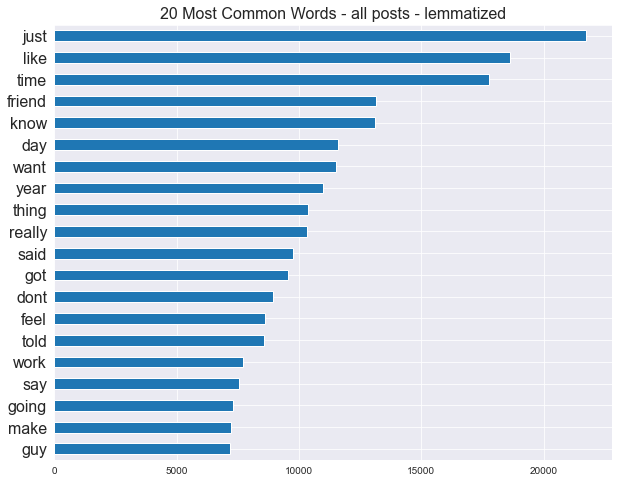

In [40]:
plt.figure(figsize=(10,8))
df_lemcvec.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('20 Most Common Words - all posts - lemmatized', size=16);

## 34,000 columns = too many
Planned to visualize total data and then trim from there, but it is just too large.  Even a simple subset and barh plot did not complete after being run overnight.  So I will tun hyperparameters NOW and work with smaller datasets.

In [43]:
lem_cvec = CountVectorizer(stop_words=custom_stop, min_df=.01, max_df=.98)
lem_allposts_cvec = lem_cvec.fit_transform(combo_structured['lem_selftext'])

In [44]:
#min=.03 , max=.95 -> 680 col.  Same @ max_df=.98
#min=.01, max=.98 -> 1659 col.  Same @ max=.95
lem_allposts_cvec.shape

(12008, 1659)

In [45]:
df_lemcvec = pd.DataFrame(lem_allposts_cvec.todense(), columns=lem_cvec.get_feature_names())
cols_to_merge = list(combo_structured.drop(columns=['is_self', 'year','selftext', 'mod_selftext','score', 'created_utc', 'lem_selftext', 'title']).columns)
#didn't merge 'year' and 'title' bc those words are present in vectorized data
#can retrieve year from timestamp later if necessary

In [46]:
vec_merge = pd.concat([df_lemcvec, combo_structured[cols_to_merge]], axis=1)

In [47]:
#object columns merged from combo_struc = ['subreddit', 'title', 'author', 'timestamp']
#df_lemcvec.columns
{'title'}.issubset(df_lemcvec.columns) #True  #you sneaky sneak
# this messed up 'sums' because vec'd column 'title' and structure column 'title'
# drop title from combo_struc df before merging vectorized data

True

In [48]:
print(f'shape: {vec_merge.shape}, size: {round(sys.getsizeof(vec_merge)/1000000,1)} MB')

shape: (12008, 1670), size: 162.6 MB


In [62]:
#export for modeling in separate notebook
vec_merge.to_csv('./data/vec_merge_ngram1.csv', index=False)

In [50]:
#subsets for barplots
pettyrev=vec_merge[vec_merge['subreddit']=='pettyrevenge']
relatadv=vec_merge[vec_merge['subreddit']=='relationship_advice']

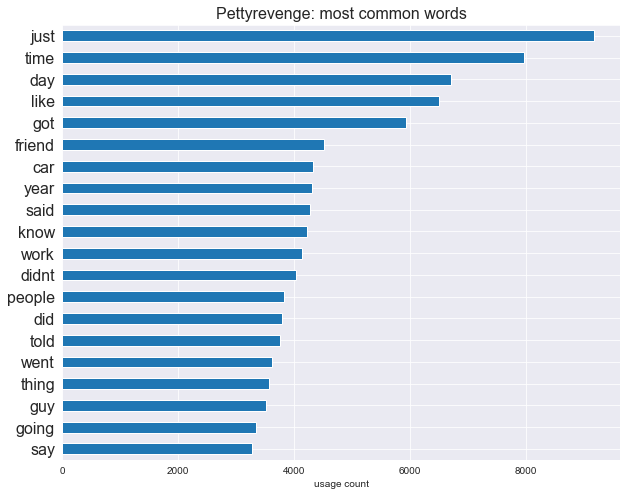

In [51]:
plt.figure(figsize=(10,8))
plt.title('Pettyrevenge: most common words', size=16);
plt.yticks(fontsize=16)
plt.xlabel('usage count')
pettyrev[lem_cvec.get_feature_names()].sum().sort_values(ascending=True).tail(20).plot(kind='barh');

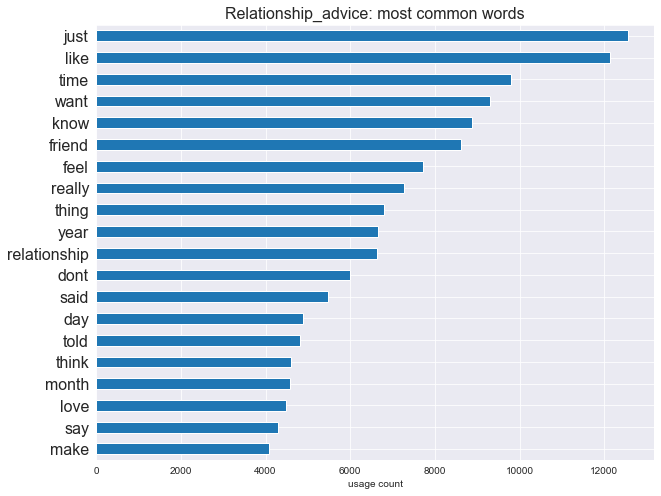

In [52]:
plt.figure(figsize=(10,8))
plt.title('Relationship_advice: most common words', size=16)
plt.yticks(size=16)
plt.xlabel('usage count')
relatadv[lem_cvec.get_feature_names()].sum().sort_values(ascending=True).tail(20).plot(kind='barh');

### More stopwords?
The above barplots share many words.  That probably means they are not useful for differentiating between subreddits. 
'Time' is probably overrepresented because a common intro in posts is 'first time posting'.  
'Like' may be an identifier for relationship_advice, but it's value is compromised since it is such a uniquitous filler word.  

However, we are talking a handful of words here.  Perhaps I should let the models determine their importance later. Move on to modeling, and consider expanding stopwords there (or dropping those vectorized-cols from the modeling dataframe if seems helpful.

---

### Check bigrams first
Context may make some of these common individual words more unique to a particular subreddit ie 'do like' vs 'not like'.  
Bigrams were more interesting.  Include bigrams in vectorized data for modeling - or gridsearch ngram_range=(1,1) vs (1,2) to see if helpful?  
Dataframe containing subreddit, author, vectorized ngram=1, and bigrams for lemmatized posts exported as csv at the end of this cell block.

In [54]:
cv_bigram = CountVectorizer(ngram_range=(2,2), stop_words=custom_stop, min_df=.01, max_df=.98)
fit_bigram=cv_bigram.fit_transform(combo_structured['lem_selftext'])
df_bigram = pd.DataFrame(fit_bigram.todense(), columns = cv_bigram.get_feature_names())

In [57]:
bigram_merge = pd.concat([df_bigram, combo_structured[cols_to_merge]], axis=1)

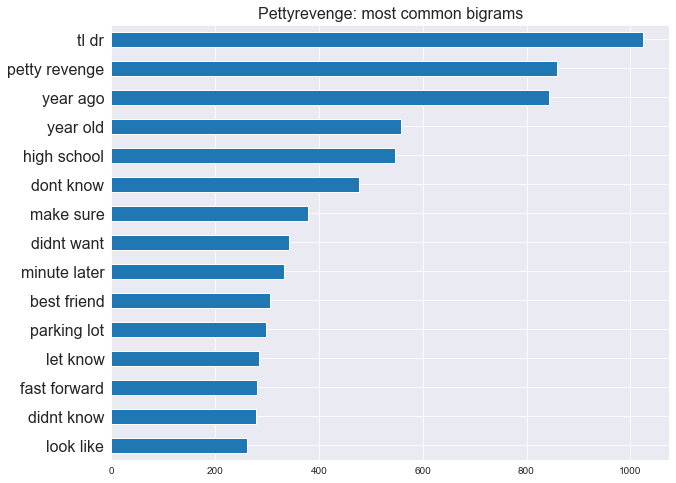

In [60]:
plt.figure(figsize=(10,8))
plt.title('Pettyrevenge: most common bigrams', size=16)
plt.yticks(size=16)
bigram_merge[bigram_merge['subreddit']=='pettyrevenge'][cv_bigram.get_feature_names()].sum().sort_values(ascending=True).tail(15).plot(kind='barh');

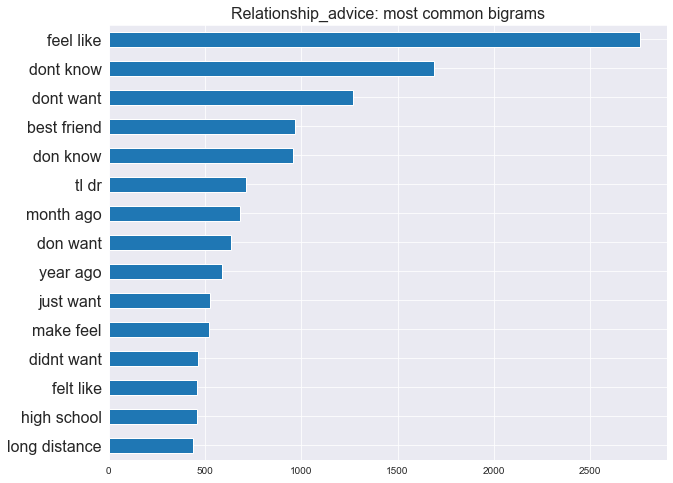

In [61]:
plt.figure(figsize=(10,8))
plt.title('Relationship_advice: most common bigrams', size=16)
plt.yticks(size=16)
bigram_merge[bigram_merge['subreddit']=='relationship_advice'][cv_bigram.get_feature_names()].sum().sort_values(ascending=True).tail(15).plot(kind='barh');

In [68]:
bigram_1gram_merge = pd.concat([df_bigram, vec_merge], axis=1)

In [72]:
bigram_1gram_merge.to_csv('./data/merged_with_bigrams.csv', index=False)

## Notes for modeling
(Modeling in separate notebook)